In [15]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np

def parse_txt(txt_path):
    frequency = []
    spl = []
    phase = []

    # Flag to determine if we are in the data section
    data_section = False

    with open(txt_path, "r") as file:
        for line in file:
            if data_section:
                values = line.split()
                frequency.append(float(values[0]))
                spl.append(float(values[1]))
                phase.append(float(values[2]))
            if "* Freq(Hz) SPL(dB) Phase(degrees)" in line:
                data_section = True
    return np.array(frequency), np.array(spl), np.array(phase)

In [16]:
# get all txts under the working directory
txts = []
for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith("Vector average.txt"):
            txts.append(os.path.join(root, file))

measurement_dict = {}

for txt in txts:
    name = txt.split("/")[-2]
    if measurement_dict.get(name) is None:
        measurement_dict[name] = {}
    frequency, spl, phase = parse_txt(txt)
    measurement_dict[name] = {
        'frequency': frequency,
        'amplitude': spl,
        'phase': phase
    }

print(measurement_dict)

{'Tegeler': {'frequency': array([   20.1416  ,    20.507811,    20.874021, ..., 19999.14388 ,
       19999.510091, 19999.876302]), 'amplitude': array([-3.961, -3.889, -3.82 , ..., -3.483, -3.483, -3.483]), 'phase': array([ 60.8456,  59.83  ,  58.8467, ..., -16.8187, -16.8207, -16.8228])}, 'SSL XLogic Alpha': {'frequency': array([1.98509220e+01, 2.01873780e+01, 2.05238340e+01, ...,
       1.99992989e+04, 1.99996353e+04, 1.99999718e+04]), 'amplitude': array([ 0.055,  0.049,  0.042, ..., -6.38 , -6.381, -6.381]), 'phase': array([  11.7863,   11.5971,   11.4175, ..., -129.7968, -129.8013,
       -129.8057])}, 'Rupert Neve Designs 517': {'frequency': array([1.98509220e+01, 2.01873780e+01, 2.05238340e+01, ...,
       1.99992989e+04, 1.99996353e+04, 1.99999718e+04]), 'amplitude': array([ 0.045,  0.048,  0.051, ..., -6.078, -6.078, -6.079]), 'phase': array([  9.0151,   8.8472,   8.69  , ..., -64.7015, -64.7054, -64.7094])}, 'Burl Audio B1D': {'frequency': array([1.98509220e+01, 2.01873780e+01,

In [59]:
# align the amplitude to the closest frequency to 1k
for name, measurements in measurement_dict.items():
    for measurement in measurements:
        frequency = measurement['frequency']
        amplitude = measurement['amplitude']
        phase = measurement['phase']
        idx = np.abs(frequency - 1000).argmin()
        amplitude_normalized = amplitude - amplitude[idx]
        phase_normalized = phase - phase[idx]
        measurement['amplitude'] = amplitude_normalized
        measurement['phase'] = phase_normalized

# average all measurements
averaged_measurement_dict = {}
for name, measurements in measurement_dict.items():
    averaged_measurement_dict[name] = {
        'frequency': measurements[0]['frequency'],
        'amplitude': np.zeros(len(measurements[0]['amplitude'])),
        'phase': np.zeros(len(measurements[0]['phase']))
    }
    for measurement in measurements:
        averaged_measurement_dict[name]['amplitude'] += measurement['amplitude']
        averaged_measurement_dict[name]['phase'] += measurement['phase']
    averaged_measurement_dict[name]['amplitude'] /= len(measurements)
    averaged_measurement_dict[name]['phase'] /= len(measurements)

# use "Cal" to calibrate all
cal = averaged_measurement_dict['Cal']
for name, measurements in averaged_measurement_dict.items():
    if name == 'Cal' or name == 'Tegeler' or name == 'Vertigo Sound VSP-2':
        continue
    measurements['amplitude'] -= cal['amplitude']
    measurements['phase'] -= cal['phase']

# remove cal from averaged_measurement_dict
del averaged_measurement_dict['Cal']

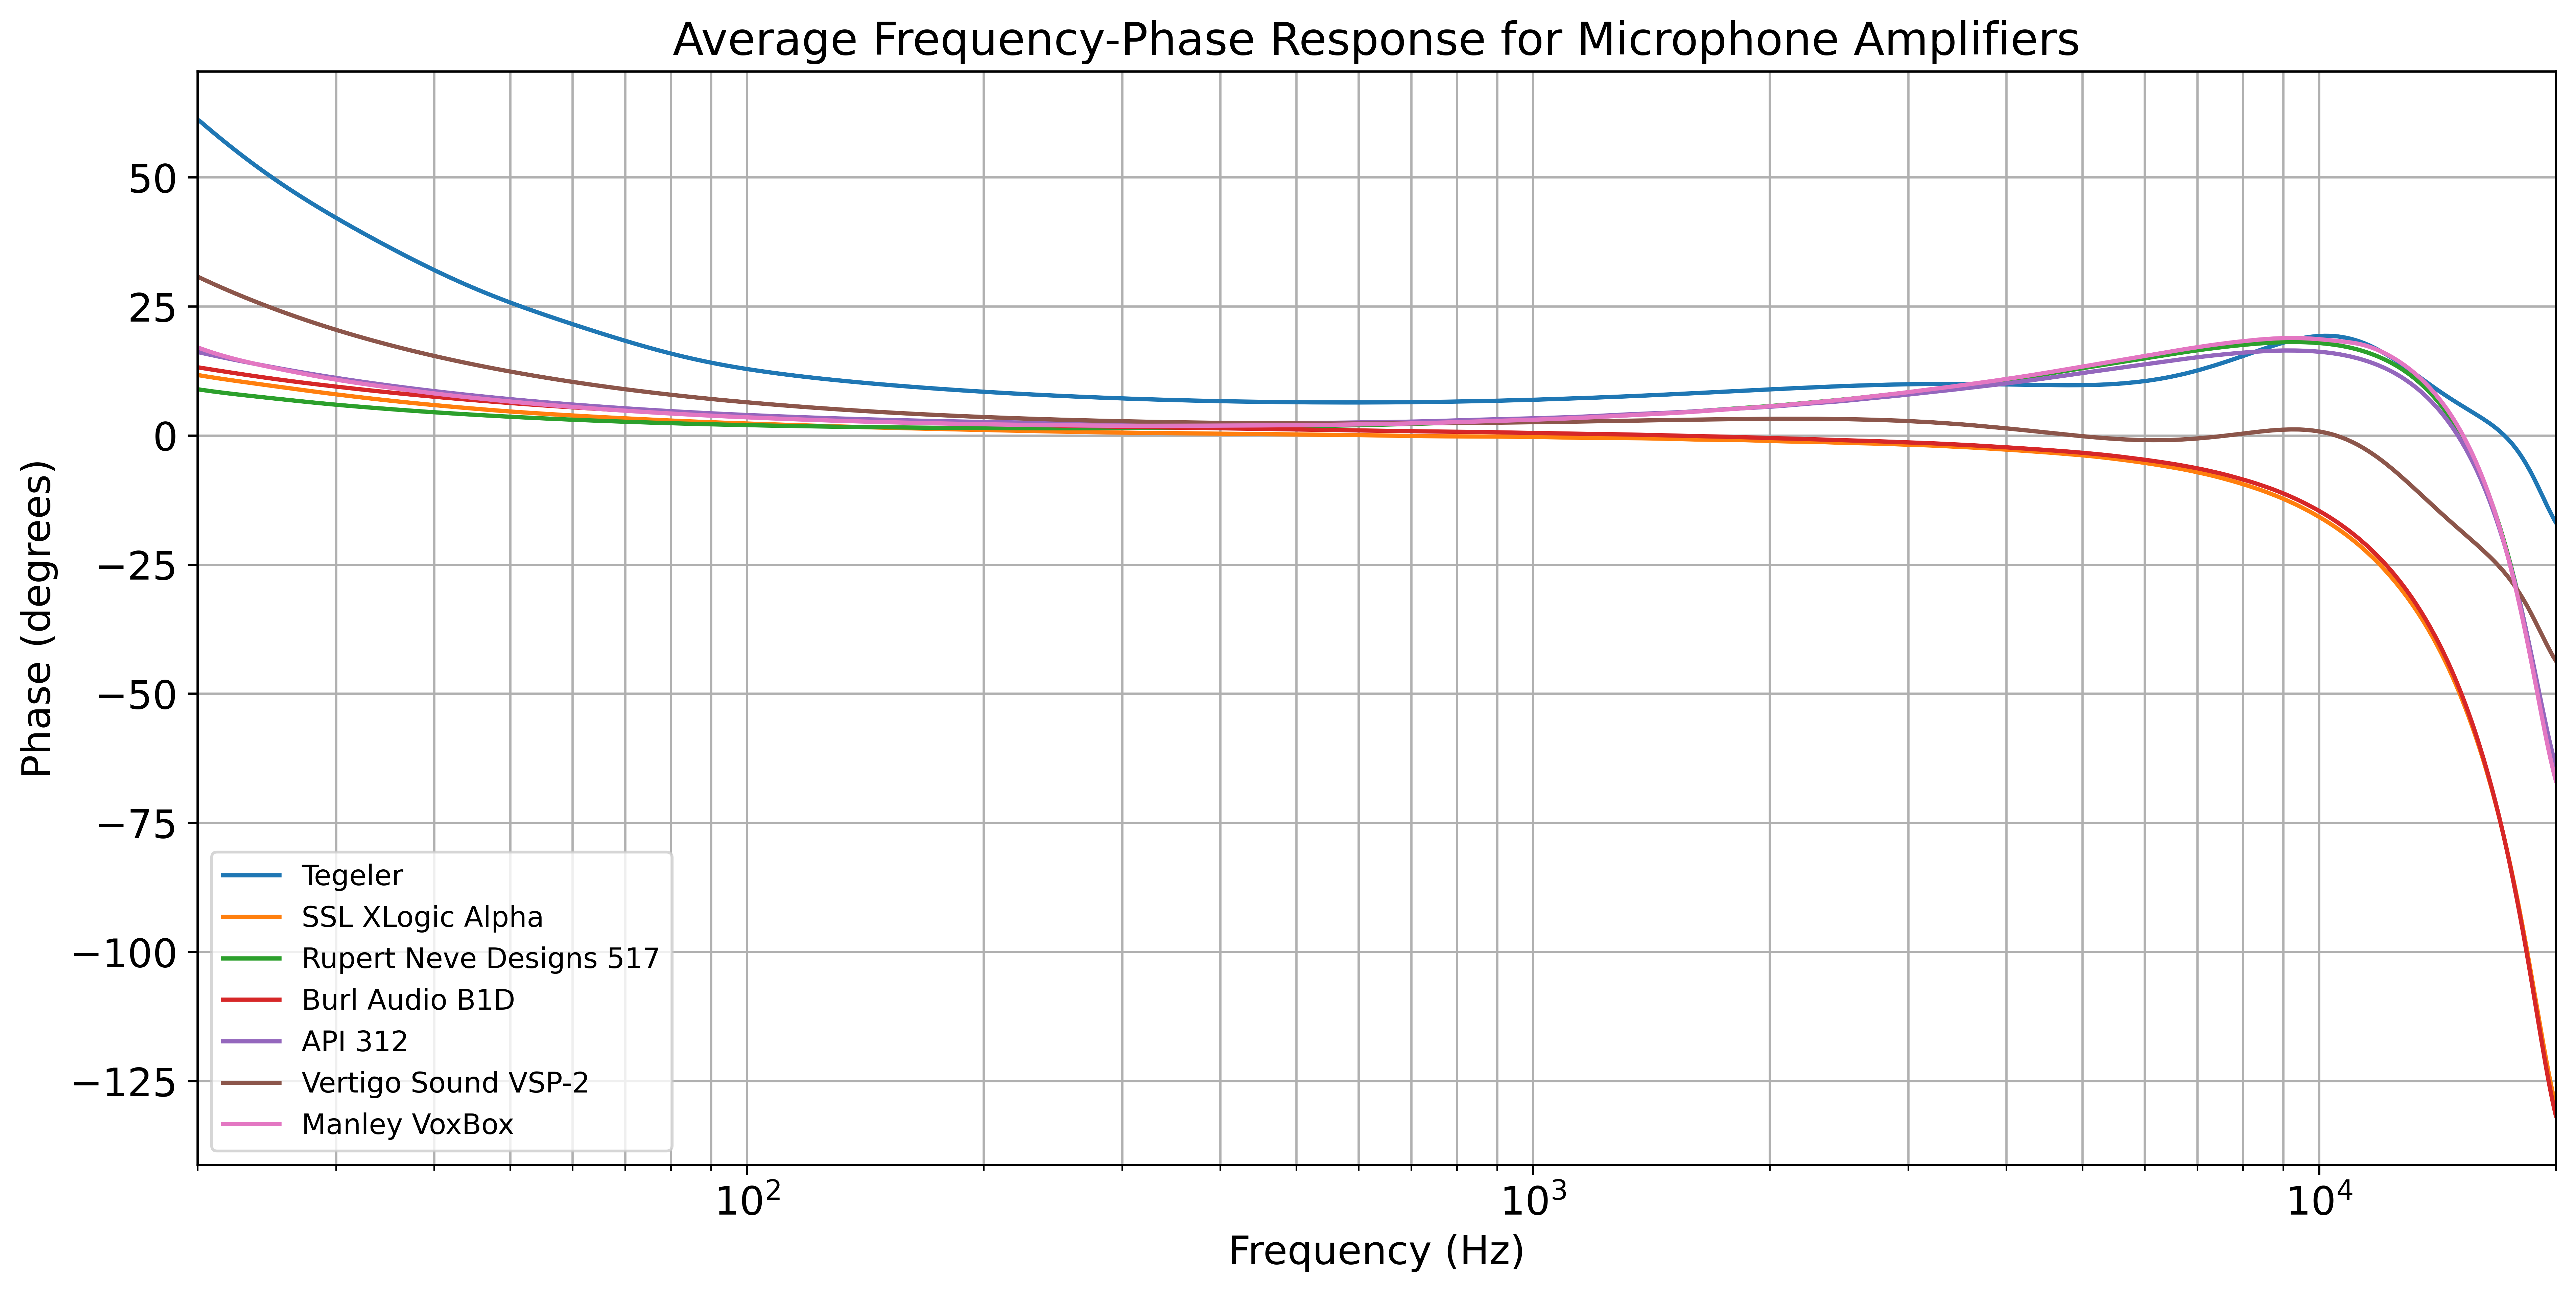

In [20]:
# plot frequency vs amplitude. name is legend
fig = plt.figure()
# set size
fig.set_size_inches(15, 7)
# set dpi
fig.set_dpi(600)
ax = fig.add_subplot(111)
ax.set_title('Average Frequency-Phase Response for Microphone Amplifiers', fontsize=16)
for name, measurements in measurement_dict.items():
    ax.plot(measurements['frequency'], measurements['phase'], label=name)
    ax.set_xlabel('Frequency (Hz)', fontsize=14)
    ax.set_ylabel('Phase (degrees)', fontsize=14)
    ax.legend()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(which='both')
plt.xscale('log')
plt.xlim(20, 20000)
# plt.ylim(-10, 1)
plt.show()